# Pixel DataLoader in `neuralhydrology`

In [24]:
from pathlib import Path
import numpy as np 
import xarray as xr 

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from neuralhydrology.utils.config import Config

import matplotlib.pyplot as plt
import seaborn as sns

# Load the data

In [25]:
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_173310")
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_200242")
run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_PIXEL_ALL_STATIC_0406_093025")

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

In [27]:
print(cfg.static_attributes)

['area', 'elev_mean', 'dpsbar', 'sand_perc', 'silt_perc', 'clay_perc', 'porosity_hypres', 'conductivity_hypres', 'soil_depth_pelletier', 'dwood_perc', 'ewood_perc', 'crop_perc', 'urban_perc', 'reservoir_cap', 'p_mean', 'pet_mean', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'low_prec_freq', 'high_prec_dur', 'low_prec_dur']


In [4]:
ds = xr.open_dataset(cfg.dynamic_nc_file)

In [5]:
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)
preds["station_id"] = preds["station_id"].astype(int)

100%|██████████| 669/669 [00:00<00:00, 2035.26it/s]


# Load model

In [6]:
# load trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)
model

Using the model weights from /datadrive/data/runs/azure_nh_runoff_30EPOCH_PIXEL_ALL_STATIC_0406_093025/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

# look at camels gb

In [7]:
st_data_dir = Path("/home/tommy/spatio_temporal/data")
static = xr.open_dataset(st_data_dir / "camels_static.nc")

# Check the Performance of model

### clip predictions to zero!

In [8]:
preds["discharge_spec_sim"] = preds["discharge_spec_sim"].clip(min=0)

# Check the Performance of model

In [9]:
run_dir

PosixPath('/datadrive/data/runs/azure_nh_runoff_30EPOCH_PIXEL_ALL_STATIC_0406_093025')

In [61]:
?calculate_all_error_metrics

Signature:
calculate_all_error_metrics(
    preds: xarray.core.dataset.Dataset,
    basin_coord: str = 'basin',
    time_coord: str = 'date',
    obs_var: str = 'discharge_spec_obs',
    sim_var: str = 'discharge_spec_sim',
    metrics: Union[List[str], NoneType] = None,
) -> xarray.core.dataset.Dataset
Docstring: <no docstring>
File:      ~/neuralhydrology/scripts/read_nh_results.py
Type:      function


In [10]:
if not (run_dir / "errors.nc").exists():
    if "errors" not in globals():
        errors = calculate_all_error_metrics(preds, basin_coord="station_id")
        errors["station_id"] = errors["station_id"].astype(int)
        errors.to_netcdf(run_dir / "errors.nc")
    else:
        print("Already run errors!")
else:
    errors = xr.open_dataset(run_dir / "errors.nc")

In [11]:
olddata_dir = Path("/datadrive/olddata/")
ref_dir = olddata_dir / "runs/ensemble_lstm_TEMP"

ref_errors = xr.open_dataset(ref_dir / "all_errors.nc")
ref = ref_errors.isel(member=1)

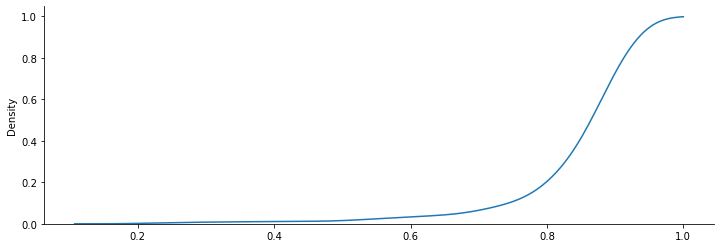

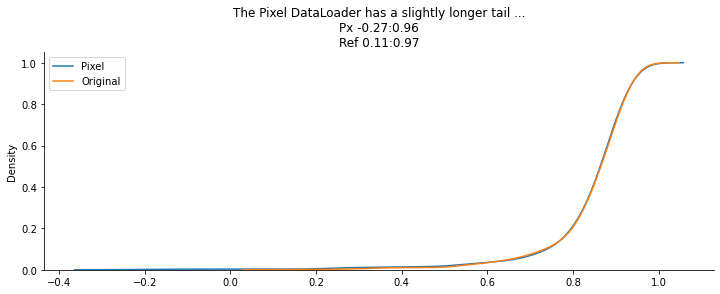

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

da = errors["NSE"].where(errors["NSE"] > 0)
f, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(da.values[np.isfinite(da)], cumulative=True, clip=(0, 1))
sns.despine()

f, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(errors["NSE"].values[np.isfinite(errors["NSE"])], cumulative=True, label="Pixel")
sns.kdeplot(ref["nse"].values[np.isfinite(ref["nse"])], cumulative=True, label="Original")
ax.legend()
px_min = float(errors["NSE"].min())
px_max = float(errors["NSE"].max())
ref_min = float(ref["nse"].min())
ref_max = float(ref["nse"].max())
ax.set_title(f"The Pixel DataLoader has a slightly longer tail ...\nPx {px_min:.2f}:{px_max:.2f}\nRef {ref_min:.2f}:{ref_max:.2f}")
sns.despine()

In [13]:
def print_summaries(errors: xr.Dataset):
    print(f"Median NSE: \t{float((errors['NSE']).median().values):.2f}")
    print(f"Mean NSE: \t{float((errors['NSE']).mean().values):.2f}")
    print(f"Min NSE: \t{float((errors['NSE']).min().values):.2f}")
    print(f"Max NSE: \t{float((errors['NSE']).max().values):.2f}")
    print(f"P(Errors < 0): \t{(errors['NSE'] < 0).mean().values:.2f}")
    print("\n")

print_summaries(errors)
print_summaries(errors.where(errors["NSE"] > 0))

print("-- Reference --")
print_summaries(ref.rename({"nse": "NSE"}))

Median NSE: 	0.87
Mean NSE: 	0.84
Min NSE: 	-0.27
Max NSE: 	0.96
P(Errors < 0): 	0.00


Median NSE: 	0.87
Mean NSE: 	0.84
Min NSE: 	0.19
Max NSE: 	0.96
P(Errors < 0): 	0.00


-- Reference --
Median NSE: 	0.87
Mean NSE: 	0.84
Min NSE: 	0.11
Max NSE: 	0.97
P(Errors < 0): 	0.00




# Scatter Plot

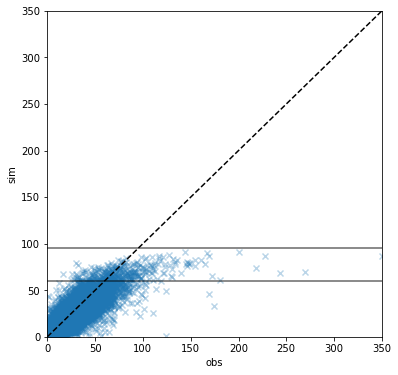

In [37]:
from scripts.plots import scatter_plot

x, y = preds["discharge_spec_obs"].values.flatten(), preds["discharge_spec_sim"].values.flatten()
scatter_plot(obs=x, sim=y)
ax = plt.gca()
ax.axhline(60, ls="-", alpha=0.6, color="k")
ax.axhline(95, ls="-", alpha=0.6, color="k");

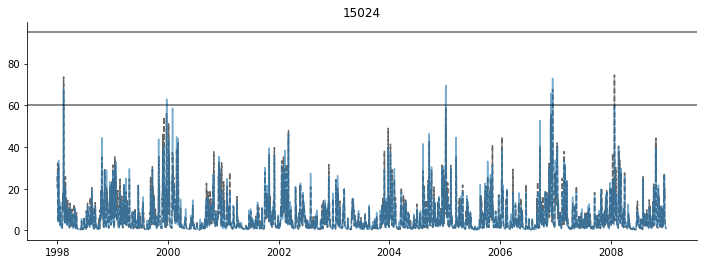

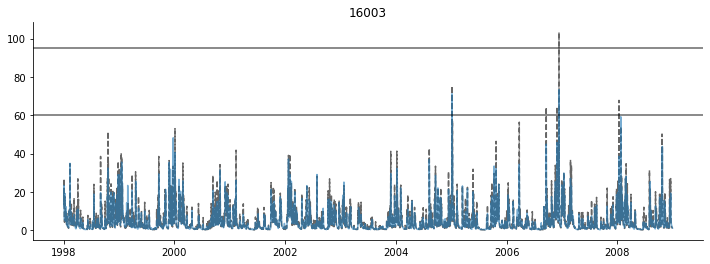

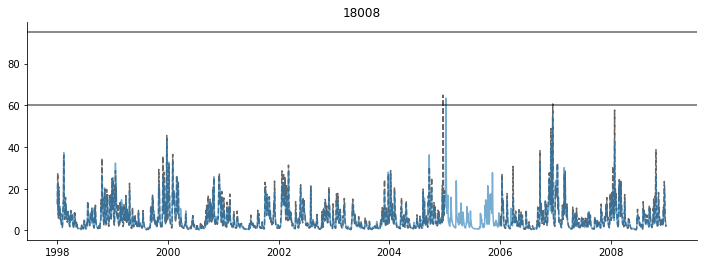

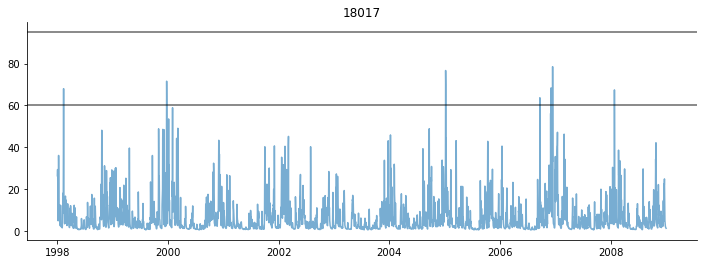

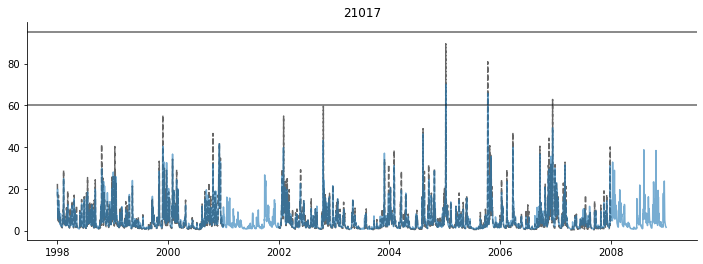

In [60]:
sids = preds.where((preds["discharge_spec_sim"] > 60) & (preds["discharge_spec_sim"] < 95), drop=True).station_id
# sids = [int(sid) for sid in ['15024', '25003', '55008', '58001', '58002']]


for sid in sids[:5]:
    f, ax = plt.subplots(figsize=(12, 4))
    d = preds.sel(station_id=sid)
    ax.plot(d["date"], d["discharge_spec_obs"], ls="--", color="k", alpha=0.6)
    ax.plot(d["date"], d["discharge_spec_sim"], color="C0", alpha=0.6)
    
    ax.axhline(60, ls="-", alpha=0.6, color="k")
    ax.axhline(95, ls="-", alpha=0.6, color="k");
    ax.set_title(str(sid.values) if isinstance(sid, xr.DataArray) else sid)
    sns.despine()

# Aridity

In [14]:
arid_stations = static.sel(station_id=static["aridity"] >= static["aridity"].quantile(0.96)).station_id.values
arid = ds.sel(station_id=np.isin(ds.station_id.values, arid_stations))
arid_errors = ref_errors.sel(station_id=np.isin(ref_errors.station_id.values, arid_stations)).sel(member="mean")
arid.dims

Frozen(SortedKeysDict({'time': 16436, 'station_id': 28}))

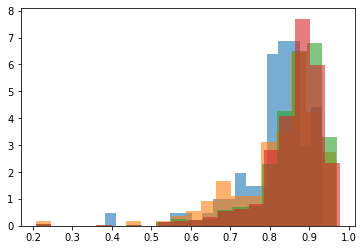

In [15]:
arid_stations = static.sel(station_id=static["aridity"] >= static["aridity"].quantile(0.9)).station_id.values
med_arid_stations = static.sel(
    station_id=(static["aridity"] >= static["aridity"].quantile(0.7)) & (static["aridity"] <= static["aridity"].quantile(0.9))
).station_id.values
lo_arid_stations = static.sel(
    station_id=((static["aridity"] >= static["aridity"].quantile(0.1)))
).station_id.values


__errors = ref_errors.sel(station_id=np.isin(ref_errors.station_id.values, arid_stations)).sel(member="mean")
_ = plt.hist(__errors["nse"].values, bins=20, color="C0", alpha=0.6, density=True)

__errors = ref_errors.sel(station_id=np.isin(ref_errors.station_id.values, med_arid_stations)).sel(member="mean")
_ = plt.hist(__errors["nse"].values, bins=20, color="C1", alpha=0.6, density=True)

__errors = ref_errors.sel(station_id=np.isin(ref_errors.station_id.values, lo_arid_stations)).sel(member="mean")
_ = plt.hist(__errors["nse"].values, bins=20, color="C2", alpha=0.6, density=True)

_ = plt.hist(ref_errors.sel(member="mean")["nse"].values, bins=20, color="C3", alpha=0.6, density=True)

In [16]:
from typing import Dict, Any
from tqdm import tqdm

def plot_precip_as_bar(precip: xr.DataArray, ax: Any, despine: bool = True, kwargs: Dict = {}):
    ax.bar(precip["time"], precip, alpha=0.4)
    ax.set_ylim([0, precip.max() + 3 * precip.std()])
    if despine:
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_ylabel("")
    ax.invert_yaxis()

Plotting: 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


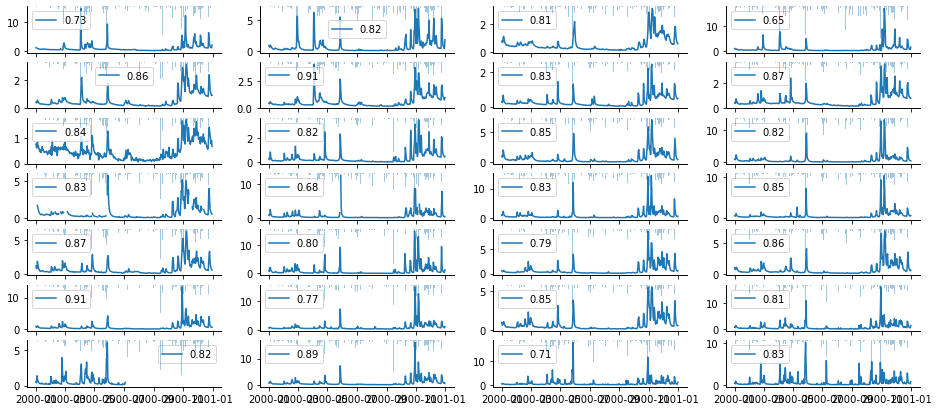

In [17]:
nrows = 7
ncols = 4
scale = 1

f, axs = plt.subplots(nrows, ncols, figsize=(4*ncols*scale, 1*nrows*scale), sharex=True, sharey=False)
pbar = tqdm(arid.station_id.values, desc="Plotting")
for ix, sid in enumerate(pbar):
    ax = axs[np.unravel_index(ix, (nrows, ncols))]
    data = arid.sel(station_id=sid)
    data = data.sel(time="2000")
    err = arid_errors["nse"].sel(station_id=sid)
    ax2 = ax.twinx()
    plot_precip_as_bar(data["precipitation"], ax=ax2, despine=True)
    ax.plot(data["time"], data["discharge_spec"], label=f"{float(err):.2f}")
    ax.legend()

sns.despine()

Plotting: 100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


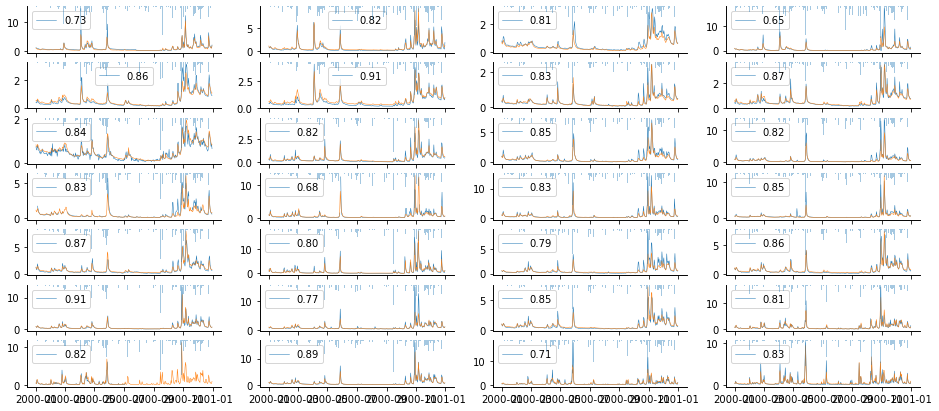

In [18]:
nrows = 7
ncols = 4
scale = 1

f, axs = plt.subplots(nrows, ncols, figsize=(4*ncols*scale, 1*nrows*scale), sharex=True, sharey=False)
pbar = tqdm(arid.station_id.values, desc="Plotting")
for ix, sid in enumerate(pbar):
    ax = axs[np.unravel_index(ix, (nrows, ncols))]
    data = arid.sel(station_id=sid)
    data = data.sel(time="2000")
    err = arid_errors["nse"].sel(station_id=sid)
    ax2 = ax.twinx()
    plot_precip_as_bar(data["precipitation"], ax=ax2, despine=True)
    
    d = preds.sel(station_id=sid, date="2000")
    ax.plot(d["date"], d["discharge_spec_obs"], label=f"{float(err):.2f}", linewidth=0.5)
    ax.plot(d["date"], d["discharge_spec_sim"], linewidth=0.5)
    ax.legend()

sns.despine()

# Visualise Hydrographs

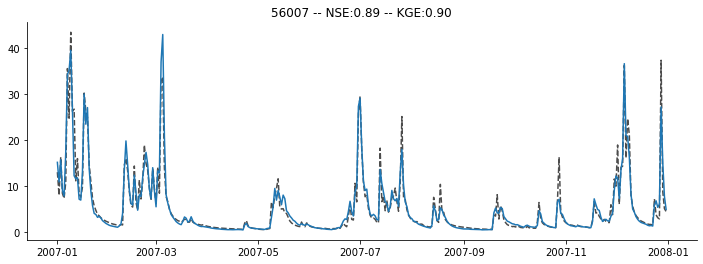

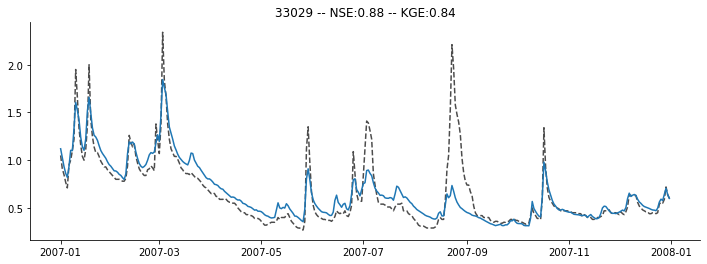

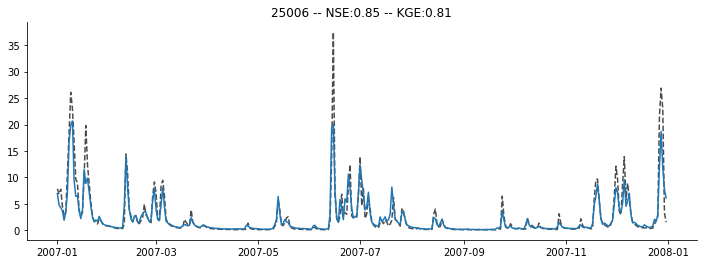

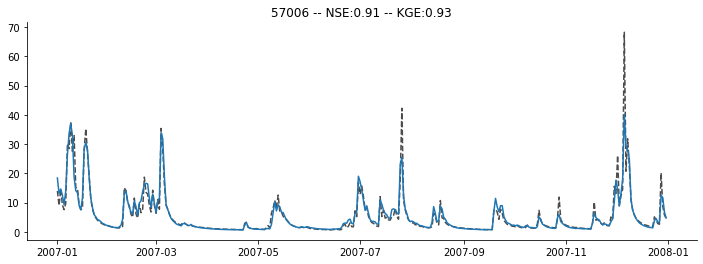

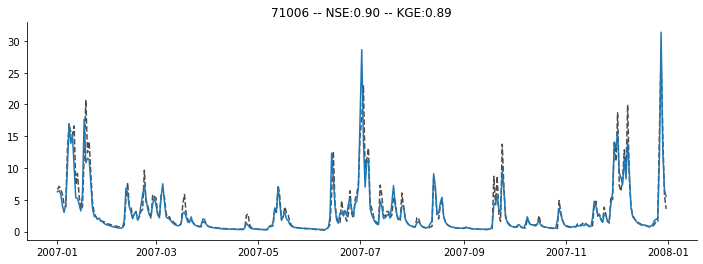

In [19]:
for i in range(5):
    f, ax = plt.subplots(figsize=(12, 4))
    pixel = np.random.choice(preds.station_id.values)
    p = preds.sel(date="2007", station_id=pixel)
    ax.plot(p.date, p["discharge_spec_obs"], label="obs", color="k", ls="--", alpha=0.7)
    ax.plot(p.date, p["discharge_spec_sim"], label="sim")
    
    ax.set_title(f"{pixel} -- NSE:{errors.sel(station_id=pixel).NSE.values:.2f} -- KGE:{errors.sel(station_id=pixel).KGE.values:.2f}")
    sns.despine()

# What about snowy catchments?

In [20]:
snowy_stations = static.sel(station_id=static["frac_snow"] > 0.05).station_id.values
err = ref_errors.sel(member="mean").drop("member")
non_snowy_stations = err.sel(station_id=~np.isin(err.station_id, snowy_stations))

In [21]:
# non_snowy_stations

In [28]:
sys.path.append("/home/tommy/ml_drought")

# from scripts.drafts.plots import plot_cdf
scale = 0.6
FIGSIZE = (12*scale, 8*scale)

clipping_lookup = {
    "nse": (0, 1.),
    "kge": (0, 1),
    "correlation": (0.5, 1),
    "bias_ratio": (0, 1.5),
    "variability_ratio": (0, 1.5),
    "bias_error": (-0.5, 0.5),
    "std_error": (-0.5, 0.5),
    "bias_error_pct": (-50, 50),
    "std_error_pct": (-50, 50),
    "flv": (-100, 100), 
    "fms": (-100, 100), 
    "fhv": (-100, 100), 
}

NameError: name 'all_metrics' is not defined

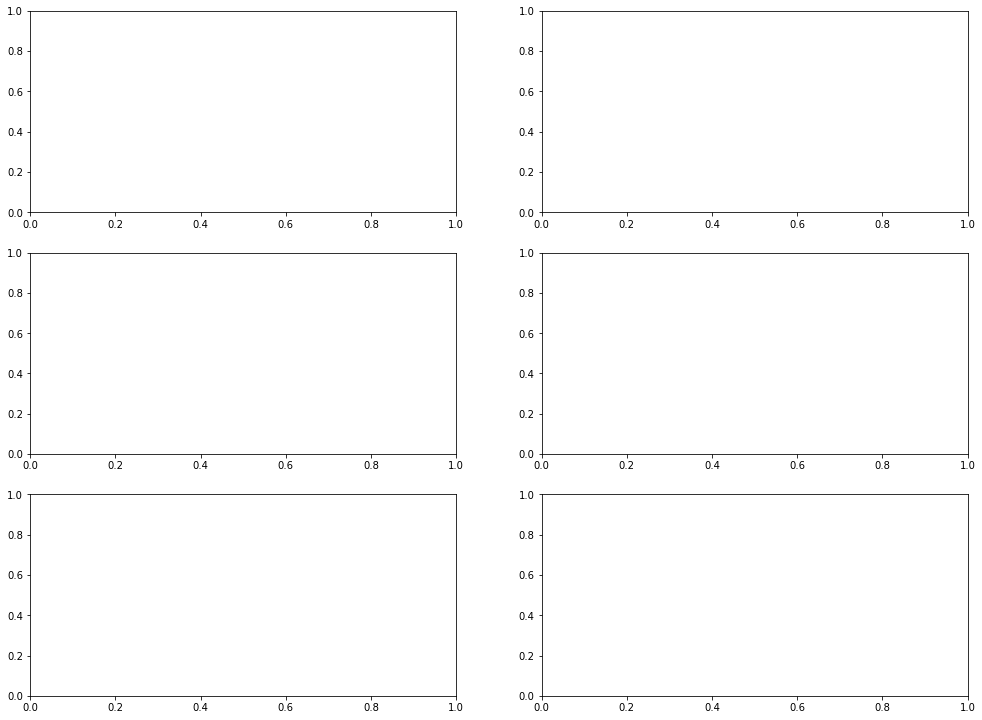

In [29]:
metric = "nse"
scale = 0.7
f, axs = plt.subplots(3, 2, figsize=(12*scale*2, 6*scale*3))

for ix, metric in enumerate(['nse', 'flv', 'fhv', 'fms', 'std_error', 'bias_error']):
    ax = axs[np.unravel_index(ix, (3, 2))]
    metric_data = all_metrics[metric]
    for col in all_metrics[metric].columns:
        sns.distplot(all_metrics[metric][col], hist=False, kde_kws=dict(cumulative=True, clip=clipping_lookup[metric]), label=col, ax=ax)
    ax.set_xlabel(metric)

    sns.despine()

# Extract the cell state

In [ ]:
from scripts.cell_state.extract_cell_state import get_cell_states

# mkdir for storing run cell states
out_dir = run_dir / "cell_states"
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

# 
if not (out_dir / "cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir)
    cn.to_netcdf(out_dir / "cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / "cell_states.nc")

# forcing the model with Climate Scenarios

In [ ]:
from copy import deepcopy

f_cfg = deepcopy(cfg)
f_cfg._cfg["dynamic_nc_file"] = f_cfg._cfg["dynamic_nc_file"].parent / "ALTERED_dynamic_ds.nc"

In [ ]:
altered_ds = xr.open_dataset(cfg.dynamic_nc_file)
if f_cfg.dynamic_nc_file.exists():
    # delete the file if already exists so we can overwrite it
    f_cfg.dynamic_nc_file.unlink()

In [ ]:
# precipitation made 30% higher
altered_ds["precipitation"] = altered_ds.precipitation * 1.3

# NO freezing temperatures and warming
altered_ds["temperature"] = (
    altered_ds["temperature"]
    # update positive temperatures to be 30% higher
    .where(altered_ds.temperature < 0, altered_ds.temperature * 1.3)
    # update negative temperatures to be 1degC (no zero-degree days)
    .where(altered_ds.temperature > 0, 1)
)

In [ ]:
def flat_finite(arr):
    return arr[np.isfinite(arr)]

f, ax = plt.subplots()
ax.hist(flat_finite(altered_ds.temperature.values), label="Temp +30%", bins=100, alpha=0.6)
ax.hist(flat_finite(ds.temperature.values), label="Control Temp", bins=100, alpha=0.6)
plt.legend()
ax.set_title("Temp")

f, ax = plt.subplots()
ax.hist(flat_finite(np.log(flat_finite(altered_ds.precipitation.values))), label="Precip +30%", bins=100, alpha=0.6)
ax.hist(flat_finite(np.log(flat_finite(ds.precipitation.values))), label="Control Precip", bins=100, alpha=0.6)
plt.legend()
ax.set_title("Log Precip")

In [ ]:
input("Do you want to continue?")
altered_ds.to_netcdf(f_cfg.dynamic_nc_file)

### run forward pass with the altered dataset

In [ ]:
from neuralhydrology.evaluation import get_tester
from scripts.read_nh_results import _load_dict_to_xarray

tester = get_tester(cfg=f_cfg, run_dir=f_cfg.run_dir, period="test", init_model=True)
results = tester.evaluate(epoch=None, save_results=False, metrics=f_cfg.metrics)
forced_pred = _load_dict_to_xarray(results)

In [ ]:
station = np.random.choice(preds.station_id.values)

f, ax = plt.subplots(figsize=(12, 4))
obs = preds["discharge_spec_obs"].sel(station_id=station, date="2007")
orig = preds["discharge_spec_sim"].sel(station_id=station, date="2007")
# forc = forced_pred_rainfall["discharge_spec_sim"].sel(station_id=station, date="2007")
forc_both = forced_pred["discharge_spec_sim"].sel(station_id=station, date="2007")

ax.plot(orig.date.values, orig.values, label="Control Expt.")
# ax.plot(forc.date.values, forc.values, label="Forced Precip [+ 30%]")
ax.plot(forc_both.date.values, forc_both.values, label="Forced Precip [+ 30%] Temp [+30%]")
ax.plot(obs.date.values, obs.values, label="Observed Q", color="k", ls=":")
ax.set_title(str(station))
sns.despine()
plt.legend()